In [39]:
import numpy as np
import pandas as pd
import skimage.io as sio
import matplotlib.pyplot as plt

import diff_classifier.aws as aws
import diff_register.register as reg
import diff_register.im_process as imp

One of the key features of diff_register is extracting cellular properties from input images. This demo notebook will show how to extract cellular properties without incorporating any accompanying multi-particle tracking datasets.

As an example dataset, I have included a large tif image of a DAPI stain in a brain slice from which we would like to extract cellular features. As DAPI stains cell nuclei, and cell nuclei are round, the resulting branch/process features won't be very informative, but users can see how they would be used

In [51]:
cprefix = 'P10_PAM_Iba_tilescan-MaxIP_L_hipp'
cfile = 'C:/Users/enuser/Desktop/P01/{}.tif'.format(cprefix)
newprefix = 'P10_PAM_L_hipp'
newfile = '{}.tif'.format(newprefix)
#cfolder = 'Tissue_Studies/04_23_18_Registration_Test'

#aws.download_s3('{}/{}'.format(cfolder, cfile), cfile, bucket_name='ccurtis.data')

cim = sio.imread(cfile)

pxrat_cells = 1.24
#pxrat_traj = 0.16
#dim_traj = 2048
#dim_cells = int(np.round(dim_traj*pxrat_traj/pxrat_cells, decimals=0))

In [52]:
cimm = cim[1,:,:]

Users can use the skimage.io toolbox to preview the image. This tilescan image is fairly large. If users want to view a subset of the image, they can use the indices of the image to zoom in.

c:\users\enuser\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\users\enuser\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


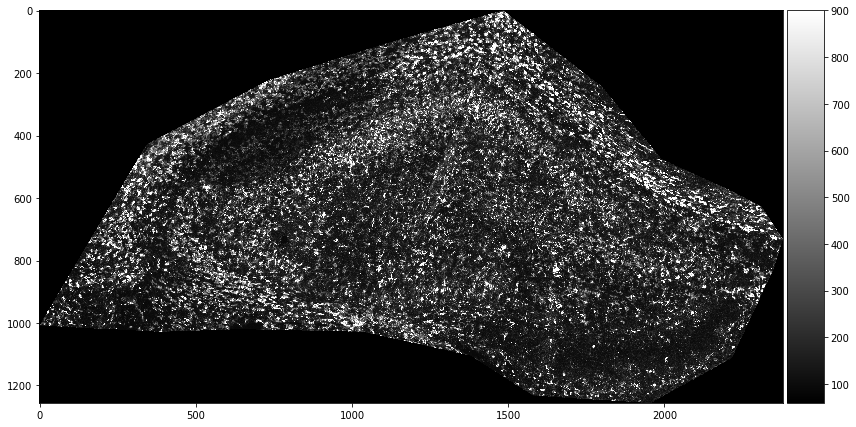

In [53]:
plt.subplots(figsize=(12,12))
sio.imshow(cimm, vmin=60, vmax=900, cmap='gray')

In [54]:
sio.imsave(newfile, cimm)

c:\users\enuser\anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: P10_PAM_L_hipp.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


diff_register can be run directly on large tilescans, but it is a good idea to optimize image processing parameters on a smaller image first. Try running skeleton_image on the small image from above.

c:\users\enuser\anaconda3\lib\site-packages\skimage\util\dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int32 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
c:\users\enuser\anaconda3\lib\site-packages\skimage\util\dtype.py:171: UserWarning: Downcasting int32 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


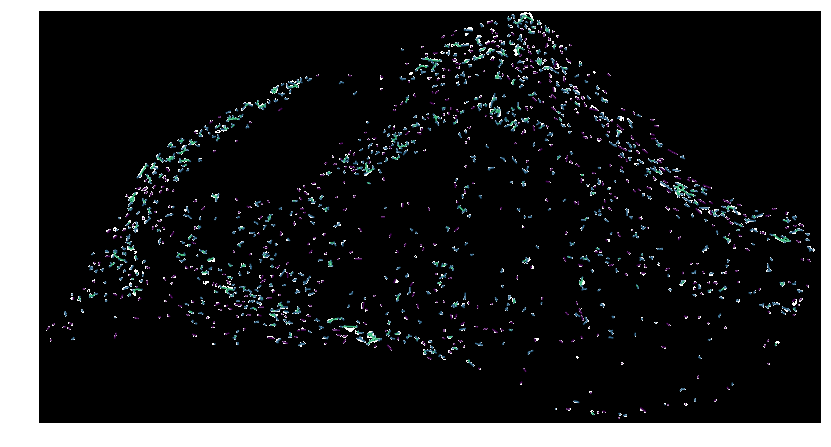

In [61]:
skel = imp.skeleton_image('.', newfile, 32, 35, tofilt=True, show=True, imname='skel_{}'.format(newfile),
                   channel=None, figsize=(14,14), ajar=False, close=False)

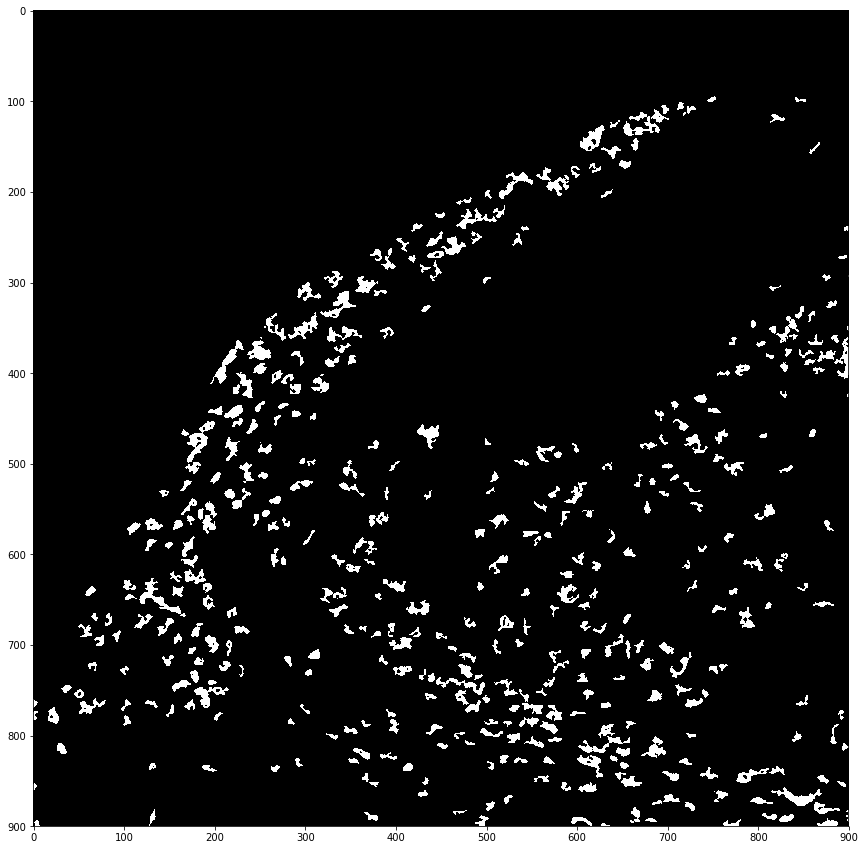

In [62]:
plt.subplots(figsize=(15,15))
plt.imshow(skel.shortim[100:1000, 100:1000], cmap='gray')

In [63]:
Dfeatures = imp.mglia_features(skel, umppx=1.24)

In [64]:
Dfeatures.describe()

,X,Y,area,average_branch,eccentricity,label,main_branch,perimeter,solidity,total_branches
count,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000
mean,750.352197,1507.045813,142.253627,11.347400,0.816573,2641.115789,14.915780,59.830310,0.755610,2.891228
std,352.379954,708.599622,134.886346,6.112707,0.139951,1680.668010,7.310832,42.354942,0.120768,2.752365
min,22.940000,33.116552,53.816000,0.000000,0.184463,2.000000,0.000000,25.144936,0.433735,0.000000
25%,461.107541,910.026326,70.729600,7.002618,0.756714,1096.750000,9.707250,36.426107,0.669631,1.000000
50%,777.563555,1567.956408,101.481600,9.707250,0.859099,2621.000000,13.731609,46.870747,0.765112,3.000000
75%,1043.219785,2054.446701,158.372800,14.291042,0.918853,4143.250000,18.367987,65.826699,0.849292,3.000000
max,1538.267692,2913.001800,1848.195200,48.110747,0.993788,5595.000000,61.845841,559.110408,1.000000,32.000000


In [65]:
Dfeatures['hemisphere'] = 'L'
Dfeatures['region'] = 'hipp'

In [66]:
Dfeatures.to_csv('{}.csv'.format(newprefix))

The output of mglia_features is a pandas dataframe containing all the features of individual cells. Users can perform analyses directly on this data. For example, users can calculate average area of a cell, or the total number of cells:

In [ ]:
print('Average cell nuclei area: {} +/- {}'.format(np.round(np.mean(Dfeatures['area']), 1),
                                                   np.round(np.std(Dfeatures['area']), 1)))
print('Cell count : {}'.format(Dfeatures.shape[0]))

In [98]:
hemis = ['R', 'L']
regs = ['cor', 'hipp', 'thal']
types = ['PAM', 'LPS']
count = 0

for typ in types:
    for hemi in hemis:
        for reg in regs:
            filename = 'C:/Users/enuser/Desktop/P01/P10_{}_{}_{}.csv'.format(typ, hemi, reg)
            mglia = pd.read_csv(filename)
            mglia['Injury'] = typ
            mglia['Subgroup'] = typ + ' ' + hemi
            if count == 0:
                mglias = mglia
            else:
                mglias = pd.concat((mglias, mglia))
            count = count + 1

In [97]:
'typ' + 'typ'

'typtyp'

In [78]:
mglias.describe(percentiles=[0.05, 0.95])

,Unnamed: 0,X,Y,area,average_branch,eccentricity,label,main_branch,perimeter,solidity,total_branches
count,7860.000000,7860.000000,7860.000000,7860.000000,7860.000000,7860.000000,7860.000000,7860.000000,7860.000000,7860.000000,7860.000000
mean,850.305216,1400.752933,1907.948806,144.296522,11.729141,0.834316,4755.311578,15.640497,63.097808,0.717130,3.136514
std,667.553335,1265.185879,1274.036314,148.336620,6.568055,0.130461,3382.192781,7.330760,48.701101,0.134388,3.223027
min,0.000000,4.264390,12.577143,53.816000,0.000000,0.155946,1.000000,0.000000,22.195374,0.326531,0.000000
5%,65.000000,148.580207,235.192097,56.891200,4.764743,0.563814,289.950000,6.341220,29.378561,0.488687,1.000000
50%,703.500000,1027.195612,1668.740962,103.019200,9.802503,0.873072,4193.000000,14.454499,49.049873,0.719298,3.000000
95%,2319.050000,4420.582950,4333.416103,352.110400,24.675374,0.971002,11166.100000,29.635374,139.196372,0.931074,8.000000
max,2712.000000,6236.920000,4720.416170,3621.048000,59.358872,0.993858,12776.000000,61.845841,1071.980760,1.000000,77.000000


In [89]:
mglias.columns

Index(['Unnamed: 0', 'X', 'Y', 'area', 'average_branch', 'eccentricity',
       'inertia_tensor', 'label', 'main_branch', 'moments', 'perimeter',
       'solidity', 'total_branches', 'hemisphere', 'region'],
      dtype='object')

In [ ]:
#PAM L cor
5898214

#PAM R cor
12380886

#PAM L hipp
1187018

#Pam R hipp
2940483

#PAM L thal
5303738

#PAM R thal
2708496

#LPS L cor
2779084

#LPS R cor
4241960

#LPS L hipp
2689968

#LPS R hipp
2383188

#LPS L thal
1034764

#LPS R thal
1845119

In [82]:
test = np.array([5898214, 12380886, 1187018,2940483,5303738,2708496,2779084, 4241960, 2689968,2383188, 1034764,1845119])
test*1.24

array([ 7313785.36, 15352298.64,  1471902.32,  3646198.92,  6576635.12,
        3358535.04,  3446064.16,  5260030.4 ,  3335560.32,  2955153.12,
        1283107.36,  2287947.56])

In [146]:
mglias.size

191879

In [157]:
nPL = [0, 2, 4]
nPR = [1, 3, 5]
nLL = [6, 8, 10]
nLR = [7, 9, 11]
dens = [0]*4
a = 0
counter = 0
for typ in types:
    b = 0
    for hemi in hemis:
        nums = [6*a+b, 6*a+b+2, 6*a+b+4]
        areas = np.sum(test[nums]*1.24)
        dens[counter] = mglias[(mglias['hemisphere']==hemi) & (mglias['Injury']==typ)].size/areas*1000
        print(dens)
        counter = counter + 1
        b = 0 + 1
    a = a + 1

[3.2888255674460893, 0, 0, 0]
[3.2888255674460893, 3.7167723233538603, 0, 0]
[3.2888255674460893, 3.7167723233538603, 2.561151493910056, 0]
[3.2888255674460893, 3.7167723233538603, 2.561151493910056, 3.5802657049196798]


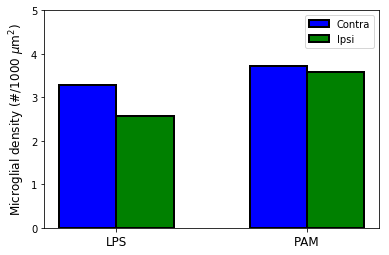

In [176]:
N = 2

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.3         # the width of the bars
p1 = ax.bar(ind, dens[0:2], width, color='b', bottom=0, edgecolor='k', linewidth=2)
p2 = ax.bar(ind + width, dens[2:4], width, color='g', bottom=0, edgecolor='k', linewidth=2)

ax.set_ylabel(r'Microglial density (#/1000 $\mu$' + r'm$^2$)', fontsize=12)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('LPS', 'PAM'), fontsize=12)
ax.set_ylim([0, 5])

ax.legend((p1[0], p2[0]), ('Contra', 'Ipsi'))

plt.show()

In [110]:
mPAMR, bins = np.histogram(mglias[(mglias['hemisphere']=='R') & (mglias['Injury']=='PAM')]['total_branches'],
                           bins=np.linspace(0, 30, 16))

mPAML, bins = np.histogram(mglias[(mglias['hemisphere']=='L') & (mglias['Injury']=='PAM')]['total_branches'],
                           bins=np.linspace(0, 30, 16))

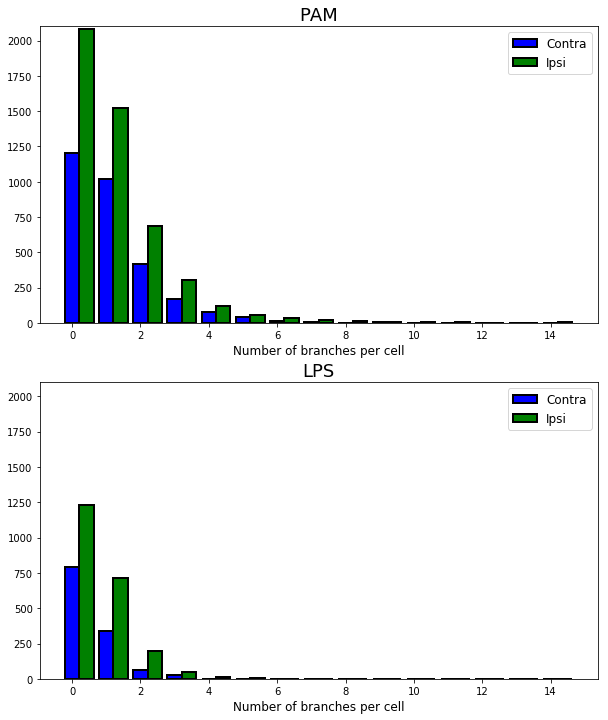

In [155]:
bins = np.linspace(0, 30, 16)
N = bins.shape[0]

fig, axes = plt.subplots(nrows=2, figsize=(10,12))

ind = np.arange(N-1)    # the x locations for the groups
width = 0.42       # the width of the bars
counter = 0

for ax in axes:
    mR, bins = np.histogram(mglias[(mglias['hemisphere']=='R') & (mglias['Injury']==types[counter])]['total_branches'],
                               bins=np.linspace(0, 30, 16))

    mL, bins = np.histogram(mglias[(mglias['hemisphere']=='L') & (mglias['Injury']==types[counter])]['total_branches'],
                               bins=np.linspace(0, 30, 16))

    
    p1 = ax.bar(ind, mR, width, color='b', bottom=0, edgecolor='k', linewidth=2)
    p2 = ax.bar(ind + width, mL, width, color='g', bottom=0, edgecolor='k', linewidth=2)

    ax.set_title(types[counter], fontsize=18)
    ax.set_xlabel('Number of branches per cell', fontsize=12)
    #ax.set_xticks(ind + width / 2)
    #ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
    ax.set_ylim([0, 2100])
    
    ax.legend((p1[0], p2[0]), ('Contra', 'Ipsi'), prop={'size': 12})
    
    counter = counter + 1

plt.show()

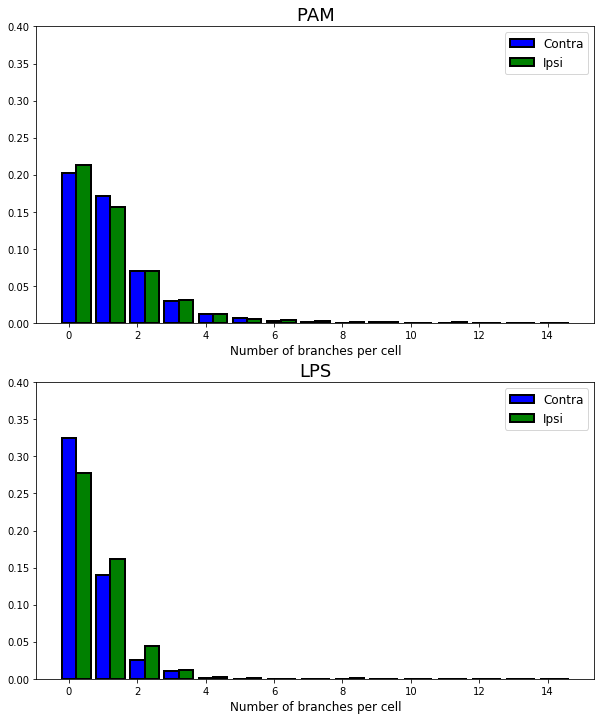

In [156]:
bins = np.linspace(0, 30, 16)
N = bins.shape[0]

fig, axes = plt.subplots(nrows=2, figsize=(10,12))

ind = np.arange(N-1)    # the x locations for the groups
width = 0.42       # the width of the bars
counter = 0

for ax in axes:
    mR, bins = np.histogram(mglias[(mglias['hemisphere']=='R') & (mglias['Injury']==types[counter])]['total_branches'],
                               bins=np.linspace(0, 30, 16), normed=True)

    mL, bins = np.histogram(mglias[(mglias['hemisphere']=='L') & (mglias['Injury']==types[counter])]['total_branches'],
                               bins=np.linspace(0, 30, 16), normed=True)

    
    p1 = ax.bar(ind, mR, width, color='b', bottom=0, edgecolor='k', linewidth=2)
    p2 = ax.bar(ind + width, mL, width, color='g', bottom=0, edgecolor='k', linewidth=2)

    ax.set_title(types[counter], fontsize=18)
    ax.set_xlabel('Number of branches per cell', fontsize=12)
    #ax.set_xticks(ind + width / 2)
    #ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
    ax.set_ylim([0, 0.4])
    
    ax.legend((p1[0], p2[0]), ('Contra', 'Ipsi'), prop={'size': 12})
    
    counter = counter + 1

plt.show()

In [115]:
mPAML.shape

(15,)